In [1]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [2]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, _ = dataset.load(subject_as_feature=True)

In [3]:
print(G.nodes)

<bound method StellarGraph.nodes of <stellargraph.core.graph.StellarGraph object at 0x0000021F1F8DB2C8>>


In [57]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [58]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 542 positive and 542 negative edges. **


In [59]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)



** Sampled 488 positive and 488 negative edges. **


In [60]:
epochs = 50

In [61]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [62]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [63]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [64]:
x_inp, x_out = gcn.in_out_tensors()

In [65]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [66]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [67]:
model = keras.Model(inputs=x_inp, outputs=prediction)

history = model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

In [68]:
print(history)

None


In [69]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 127ms/step - loss: 2.0300 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 2.0826
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 2.0300
	binary_accuracy: 0.5000


In [70]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 1s - loss: 2.0295 - binary_accuracy: 0.5000 - val_loss: 0.7906 - val_binary_accuracy: 0.5978 - 1s/epoch - 1s/step
Epoch 2/50
1/1 - 0s - loss: 0.9151 - binary_accuracy: 0.5799 - val_loss: 3.9607 - val_binary_accuracy: 0.5185 - 133ms/epoch - 133ms/step
Epoch 3/50
1/1 - 0s - loss: 4.1121 - binary_accuracy: 0.5041 - val_loss: 0.6921 - val_binary_accuracy: 0.6310 - 147ms/epoch - 147ms/step
Epoch 4/50
1/1 - 0s - loss: 0.7919 - binary_accuracy: 0.6199 - val_loss: 0.7576 - val_binary_accuracy: 0.5673 - 150ms/epoch - 150ms/step
Epoch 5/50
1/1 - 0s - loss: 0.7662 - binary_accuracy: 0.5799 - val_loss: 0.9722 - val_binary_accuracy: 0.5111 - 138ms/epoch - 138ms/step
Epoch 6/50
1/1 - 0s - loss: 0.9657 - binary_accuracy: 0.5092 - val_loss: 1.0627 - val_binary_accuracy: 0.5065 - 148ms/epoch - 148ms/step
Epoch 7/50
1/1 - 0s - loss: 1.0682 - binary_accuracy: 0.5072 - val_loss: 1.0046 - val_binary_accuracy: 0.5111 - 143ms/epoch - 143ms/step
Epoch 8/50
1/1 - 0s - loss: 0.9956 - binary_acc

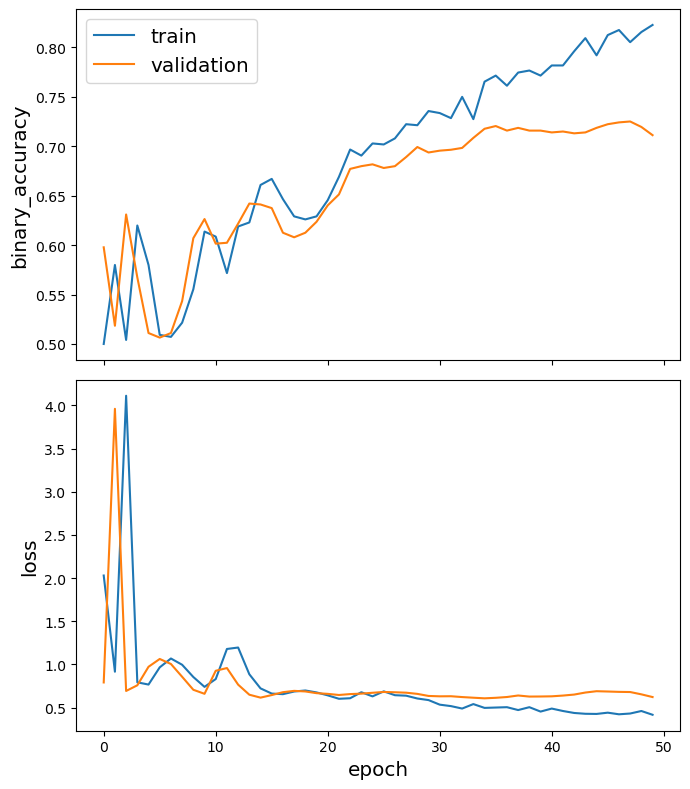

In [71]:
sg.utils.plot_history(history)

In [72]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))



1/1 [==============================] - 0s 79ms/step - loss: 0.6215 - binary_accuracy: 0.7113

Train Set Metrics of the trained model:
	loss: 0.3519
	binary_accuracy: 0.8402

Test Set Metrics of the trained model:
	loss: 0.6215
	binary_accuracy: 0.7113
